In [2]:
import requests
from PIL import Image
import os
from io import BytesIO
from glob import glob
import albumentations as A
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

# Download authentic images
os.makedirs('authentic_images', exist_ok=True)
api_key = "mOIOtvDb"
url = f"https://www.rijksmuseum.nl/api/en/collection?key={api_key}&ps=20&type=painting"
response = requests.get(url)
if response.status_code != 200:
    print(f"Error: {response.status_code} - {response.text}")
    raise Exception("Check API key.")

artworks = response.json()['artObjects']
authentic_images = []
for i, art in enumerate(artworks):
    img_url = art.get('webImage', {}).get('url')
    if img_url:
        img_response = requests.get(img_url, headers={'User-Agent': 'Mozilla/5.0'})
        if img_response.status_code == 200 and 'image' in img_response.headers['content-type']:
            img = Image.open(BytesIO(img_response.content))
            img_path = f'authentic_images/authentic_{i}.jpg'
            img.save(img_path)
            authentic_images.append(img_path)
            print(f"Saved {img_path}")

print(f"Downloaded {len(authentic_images)} images.")
!ls -l authentic_images/

# Generate fake images
os.makedirs('fake_images', exist_ok=True)
transform = A.Compose([
    A.GaussianBlur(blur_limit=(7, 15), p=0.8),  # Stronger blur
    A.GaussNoise(var_limit=(50.0, 100.0), p=0.8),  # More noise
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.8),  # Stronger contrast
    A.Rotate(limit=30, p=0.7),  # Larger rotation
    A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2, p=0.7),  # Color changes
])

fake_images = []
for path in authentic_images:
    image = cv2.imread(path)
    if image is None:
        print(f"Failed to load {path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image)['image']
    fake_path = path.replace('authentic_images', 'fake_images').replace('authentic', 'fake')
    cv2.imwrite(fake_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
    fake_images.append(fake_path)
    print(f"Generated {fake_path}")

print(f"Generated {len(fake_images)} fakes.")
!ls -l fake_images/

# Update CSVs
authentic_labels = [1] * len(authentic_images)
fake_labels = [0] * len(fake_images)
all_paths = authentic_images + fake_images
all_labels = authentic_labels + fake_labels
df = pd.DataFrame({'image_path': all_paths, 'label': all_labels})
print(df.head())

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

# Download CSVs
from google.colab import files
files.download('train.csv')
files.download('test.csv')

Saved authentic_images/authentic_0.jpg
Saved authentic_images/authentic_1.jpg
Saved authentic_images/authentic_2.jpg
Saved authentic_images/authentic_3.jpg
Saved authentic_images/authentic_4.jpg
Saved authentic_images/authentic_5.jpg
Saved authentic_images/authentic_6.jpg
Saved authentic_images/authentic_7.jpg
Saved authentic_images/authentic_8.jpg
Saved authentic_images/authentic_9.jpg
Saved authentic_images/authentic_10.jpg
Saved authentic_images/authentic_11.jpg
Saved authentic_images/authentic_12.jpg
Saved authentic_images/authentic_13.jpg
Saved authentic_images/authentic_14.jpg
Saved authentic_images/authentic_15.jpg
Saved authentic_images/authentic_16.jpg
Saved authentic_images/authentic_17.jpg
Saved authentic_images/authentic_18.jpg
Saved authentic_images/authentic_19.jpg
Downloaded 20 images.
total 17012
-rw-r--r-- 1 root root 1000530 Sep 20 23:20 authentic_0.jpg
-rw-r--r-- 1 root root  443166 Sep 20 23:20 authentic_10.jpg
-rw-r--r-- 1 root root  620298 Sep 20 23:20 authentic_1

/tmp/ipython-input-411329384.py:40: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(50.0, 100.0), p=0.8),  # More noise


Generated fake_images/fake_0.jpg
Generated fake_images/fake_1.jpg
Generated fake_images/fake_2.jpg
Generated fake_images/fake_3.jpg
Generated fake_images/fake_4.jpg
Generated fake_images/fake_5.jpg
Generated fake_images/fake_6.jpg
Generated fake_images/fake_7.jpg
Generated fake_images/fake_8.jpg
Generated fake_images/fake_9.jpg
Generated fake_images/fake_10.jpg
Generated fake_images/fake_11.jpg
Generated fake_images/fake_12.jpg
Generated fake_images/fake_13.jpg
Generated fake_images/fake_14.jpg
Generated fake_images/fake_15.jpg
Generated fake_images/fake_16.jpg
Generated fake_images/fake_17.jpg
Generated fake_images/fake_18.jpg
Generated fake_images/fake_19.jpg
Generated 20 fakes.
total 91664
-rw-r--r-- 1 root root  4352062 Sep 20 23:20 fake_0.jpg
-rw-r--r-- 1 root root  2403777 Sep 20 23:20 fake_10.jpg
-rw-r--r-- 1 root root  2574910 Sep 20 23:20 fake_11.jpg
-rw-r--r-- 1 root root  3798732 Sep 20 23:20 fake_12.jpg
-rw-r--r-- 1 root root  1074226 Sep 20 23:20 fake_13.jpg
-rw-r--r-- 1 r

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from glob import glob

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load reference embeddings
authentic_images = glob('authentic_images/authentic_*.jpg')
ref_images = [Image.open(p) for p in authentic_images]
ref_inputs = processor(images=ref_images, return_tensors="pt").to(device)
with torch.no_grad():
    ref_embeddings = model.get_image_features(**ref_inputs).cpu().numpy()

# Test different thresholds
test_df = pd.read_csv('test.csv')
thresholds = [0.7, 0.8, 0.85, 0.9, 0.95]
for thresh in thresholds:
    predictions = []
    true_labels = []
    print(f"\nThreshold: {thresh}")
    for idx, row in test_df.iterrows():
        path = row['image_path']
        label = row['label']
        test_img = Image.open(path)
        test_input = processor(images=test_img, return_tensors="pt").to(device)
        with torch.no_grad():
            test_embedding = model.get_image_features(**test_input).cpu().numpy()
        similarities = cosine_similarity(test_embedding, ref_embeddings)[0]
        max_sim = np.max(similarities)
        pred = 1 if max_sim > thresh else 0  # 1=authentic, 0=fake
        predictions.append(pred)
        true_labels.append(label)
        print(f"{path}: Similarity={max_sim:.3f}, Pred={'authentic' if pred == 1 else 'fake'}, True={'authentic' if label == 1 else 'fake'}")
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Threshold {thresh}: Accuracy={accuracy:.3f}")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]


Threshold: 0.7
fake_images/fake_7.jpg: Similarity=0.684, Pred=fake, True=fake
fake_images/fake_14.jpg: Similarity=0.644, Pred=fake, True=fake
authentic_images/authentic_17.jpg: Similarity=1.000, Pred=authentic, True=authentic
authentic_images/authentic_11.jpg: Similarity=1.000, Pred=authentic, True=authentic
fake_images/fake_6.jpg: Similarity=0.877, Pred=authentic, True=fake
authentic_images/authentic_1.jpg: Similarity=1.000, Pred=authentic, True=authentic
fake_images/fake_10.jpg: Similarity=0.779, Pred=authentic, True=fake
authentic_images/authentic_0.jpg: Similarity=1.000, Pred=authentic, True=authentic
Threshold 0.7: Accuracy=0.750

Threshold: 0.8
fake_images/fake_7.jpg: Similarity=0.684, Pred=fake, True=fake
fake_images/fake_14.jpg: Similarity=0.644, Pred=fake, True=fake
authentic_images/authentic_17.jpg: Similarity=1.000, Pred=authentic, True=authentic
authentic_images/authentic_11.jpg: Similarity=1.000, Pred=authentic, True=authentic
fake_images/fake_6.jpg: Similarity=0.877, Pre

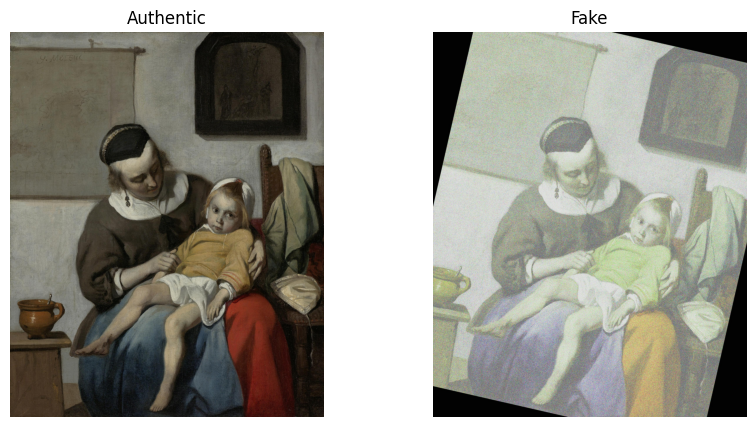

In [4]:
import cv2
import matplotlib.pyplot as plt

# Visualize authentic vs. fake
authentic_img = cv2.imread('authentic_images/authentic_0.jpg')
fake_img = cv2.imread('fake_images/fake_0.jpg')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(authentic_img, cv2.COLOR_BGR2RGB))
plt.title("Authentic")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB))
plt.title("Fake")
plt.axis('off')
plt.show()